In [1]:
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

data = fetch_ucirepo(id=162)
target = data.data.targets

data = data.data.features
data = pd.concat([target, data], axis = 1)

In [9]:
print(data.head())
print(data.columns.tolist())
print(data['month'].value_counts())

   area  X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain
0   0.0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1   0.0  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2   0.0  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3   0.0  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4   0.0  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0
['area', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64


This is a very imbalanced dataset. November has only 1 row, while August and September have 184 and 172 rows.

In [4]:
data.describe()

,area,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,12.847292,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663
std,63.655818,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959
min,0.000000,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,0.000000,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,0.520000,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,6.570000,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000
max,1090.840000,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


In [5]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

total_area_by_month = data.groupby("month").sum("area")["area"]

highest_temps = data.groupby("month")["temp"].max()

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

encoded_data = data.copy()

encoded_data["month"] = label_encoder.fit_transform(encoded_data["month"])
encoded_data["day"] = label_encoder.fit_transform(encoded_data["day"])

encoded_data.head()

,area,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0.0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,0.0,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,0.0,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,0.0,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,0.0,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


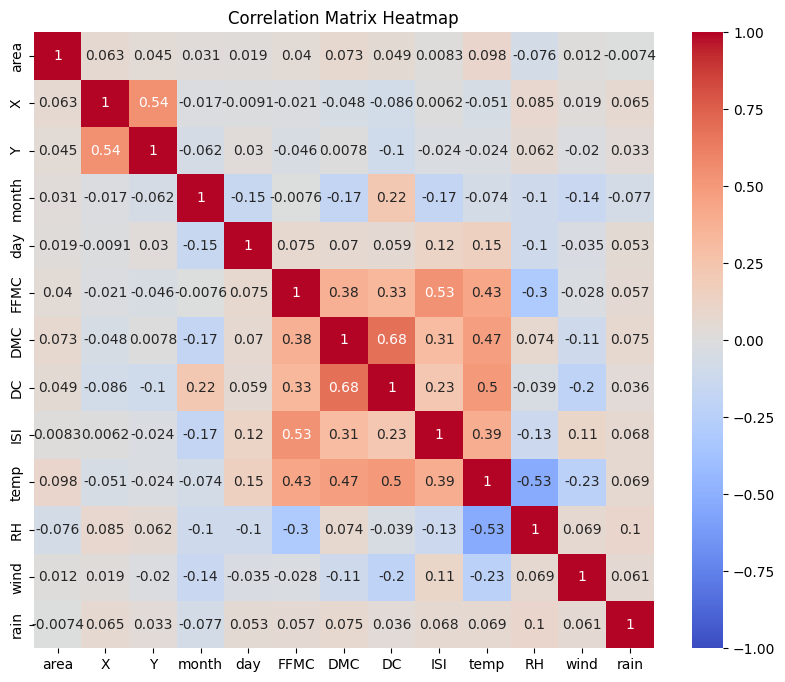

In [8]:
import seaborn as sns


corr_matrix = encoded_data.corr(method = 'pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Observation: The central values FFMC, DMC, DC and ISI have high linear correlation between themselves. Those values refer to: Fine Fuel Moisture Code(fuel from forest litter under canopy shade), Duff Moisture Code(fuel from decomposed organic material), Drought Code(drying deep into the soil) and Initial Spread Index (expected rate of fire spread).

The linearity between them is mostly due to combustion capacity, as how the amount of combustible organic material and low moisture sets in the soil and allows the flames to grow quicker.

The low linearity of the data (the highest being 0.069) with the target feature will probably lead to poor machine learning perfomance.

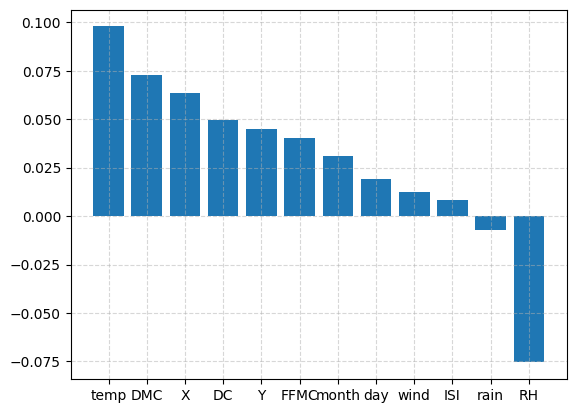

In [10]:
sorted_correlations_area = corr_matrix['area'].sort_values(ascending=False)[1:]

plt.bar(sorted_correlations_area.index, sorted_correlations_area)
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

Based on this observation, it's visible that the area of wildfires tends to grow when temperature, DMC and DC are higher, as well as when relative humidity (RH) is lower.


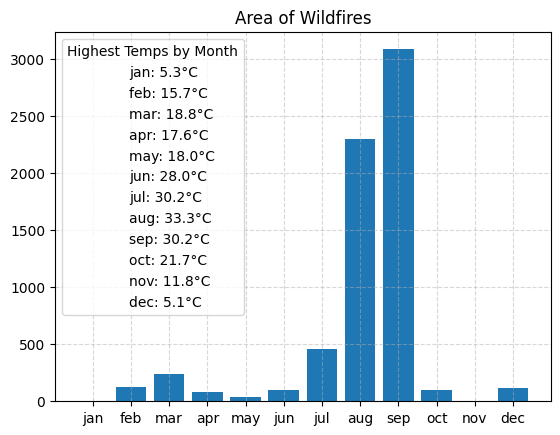

In [11]:
plt.bar(total_area_by_month.index, total_area_by_month)
handles = [plt.Line2D([0], [0], color='w', label=f'{month}: {temp}°C') for month, temp in highest_temps.dropna().items()]
plt.legend(handles=handles, title="Highest Temps by Month")
plt.title("Area of Wildfires")
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

This is the total area of wildfires by month. As expected, august and september have a really high total area, so it's better to observe it as percentages instead of absolute numbers. We'll do it in the following steps.


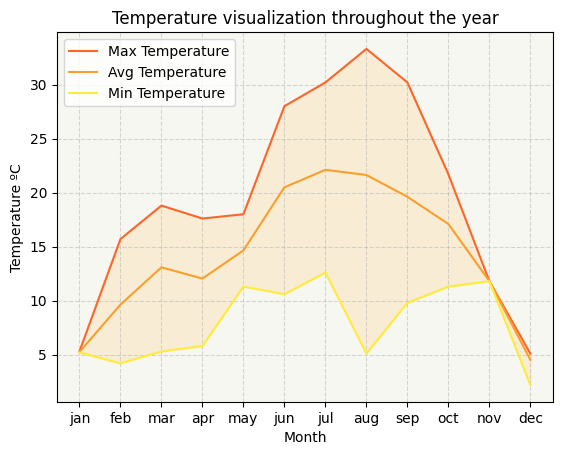

In [12]:
max_temp = data.groupby('month')['temp'].max()
avg_temp = data.groupby('month')['temp'].mean()
min_temp = data.groupby('month')['temp'].min()


plt.gca().set_facecolor('#f7f7f2')

plt.plot(max_temp.index, max_temp, color = '#fc662b', label = "Max Temperature")
plt.plot(avg_temp.index, avg_temp, color = '#fc9e2b', label = "Avg Temperature")
plt.plot(min_temp.index, min_temp, color = '#ffeb3b', label = "Min Temperature")

plt.fill_between(max_temp.index, min_temp.values, max_temp.values, color='#ffc95c', alpha=0.2)

plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Temperature visualization throughout the year")

plt.xlabel("Month")
plt.ylabel("Temperature ºC")
plt.legend()

plt.show()

This distribution indicates that temperatures rises greatly between june and september. This is mostly due to the summer in the northern hemisphere, as this dataset was taken from Portugal. Although it's not trustworthy due to the lack of sufficient data for each month.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

month_col = data["month"]
max_scaled_dataset = data[["RH", "temp", "area", "wind", "rain"]]
columns_to_scale = max_scaled_dataset.columns.tolist()

min_max_scaler = MinMaxScaler()

max_scaled_dataset = min_max_scaler.fit_transform(max_scaled_dataset)
max_scaled_dataset = pd.DataFrame(max_scaled_dataset, columns = columns_to_scale)
max_scaled_dataset = pd.concat([month_col, max_scaled_dataset], axis=1)
max_scaled_dataset.head()

month_group = max_scaled_dataset.groupby("month")
max_scaled_temp = month_group["temp"].max()
max_scaled_area = month_group["area"].max()
max_scaled_rain = month_group["rain"].max()

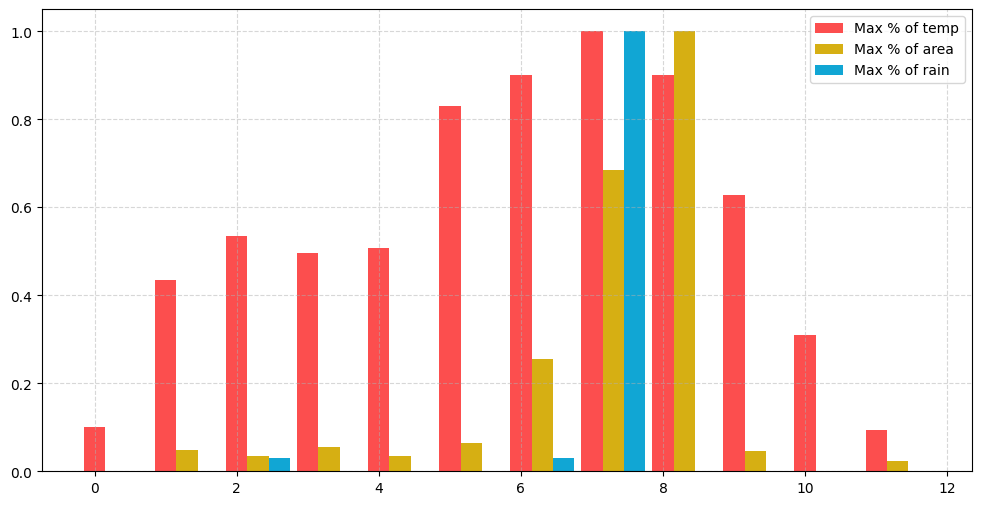

In [ ]:
index = np.arange(len(max_scaled_temp))

bar_width = 0.3

plt.figure(figsize = (12, 6))
plt.bar(index, max_scaled_temp, width=bar_width, color='#fc4e4e', label="Max % of temp")
plt.bar(index + bar_width, max_scaled_area, width=bar_width, color='#d6af13', label="Max % of area")
plt.bar(index + 2 * bar_width, max_scaled_rain, width=bar_width, color='#11a6d4', label="Max % of rain")

plt.grid(linestyle = '--', alpha = 0.5)

plt.legend()
plt.show()

In [ ]:
biological_features = data[["month", "DC", "FFMC", "DMC", "ISI"]]

max_dc = biological_features.groupby('month')['DC'].max()
avg_dc = biological_features.groupby('month')['DC'].mean()
min_dc = biological_features.groupby('month')['DC'].min()

max_ffmc = biological_features.groupby('month')['FFMC'].max()
avg_ffmc = biological_features.groupby('month')['FFMC'].mean()
min_ffmc = biological_features.groupby('month')['FFMC'].min()

max_dmc = biological_features.groupby('month')['DMC'].max()
avg_dmc = biological_features.groupby('month')['DMC'].mean()
min_dmc = biological_features.groupby('month')['DMC'].min()

max_isi = biological_features.groupby('month')['ISI'].max()
avg_isi = biological_features.groupby('month')['ISI'].mean()
min_isi = biological_features.groupby('month')['ISI'].min()

Text(0.5, 1.0, 'ISI')

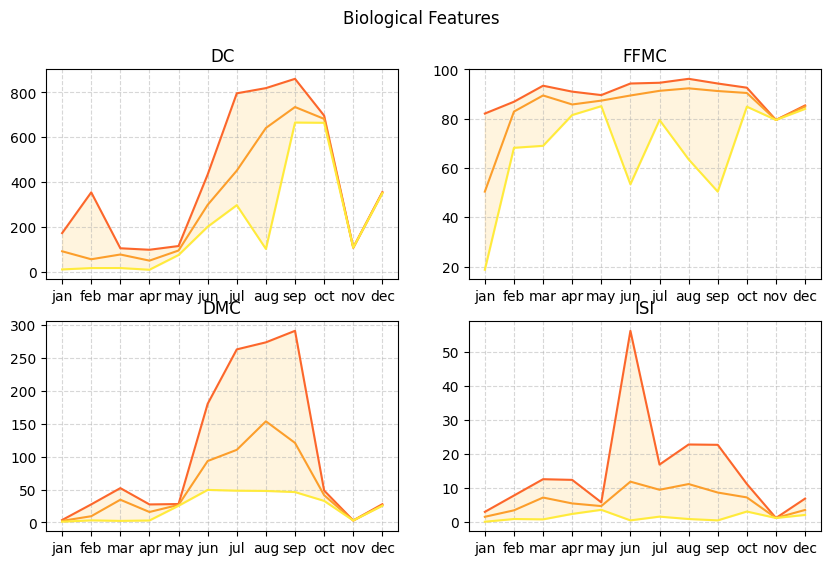

In [ ]:

fig, axs = plt.subplots(2,2, figsize = (10,6))
fig.suptitle("Biological Features")

axs[0,0].plot(max_dc.index, max_dc, color = '#fc662b', label = "Max DC")
axs[0,0].plot(avg_dc.index, avg_dc, color = '#fc9e2b', label = "Avg DC")
axs[0,0].plot(min_dc.index, min_dc, color = '#ffeb3b', label = "Min DC")
axs[0,0].fill_between(max_dc.index, min_dc.values, max_dc.values, color='#ffc95c', alpha=0.2)
axs[0,0].grid(True, linestyle='--', alpha=0.5)
axs[0,0].set_title("DC")

axs[0,1].plot(max_ffmc.index, max_ffmc, color = '#fc662b', label = "Max FFMC")
axs[0,1].plot(avg_ffmc.index, avg_ffmc, color = '#fc9e2b', label = "Avg FFMC")
axs[0,1].plot(min_ffmc.index, min_ffmc, color = '#ffeb3b', label = "Min FFMC")
axs[0,1].fill_between(max_ffmc.index, min_ffmc.values, max_ffmc.values, color='#ffc95c', alpha=0.2)
axs[0,1].grid(True, linestyle='--', alpha=0.5)
axs[0,1].set_title("FFMC")

axs[1,0].plot(max_dmc.index, max_dmc, color = '#fc662b', label = "Max DMC")
axs[1,0].plot(avg_dmc.index, avg_dmc, color = '#fc9e2b', label = "Avg DMC")
axs[1,0].plot(min_dmc.index, min_dmc, color = '#ffeb3b', label = "Min DMC")
axs[1,0].fill_between(max_dmc.index, min_dmc.values, max_dmc.values, color='#ffc95c', alpha=0.2)
axs[1,0].grid(True, linestyle='--', alpha=0.5)
axs[1,0].set_title("DMC")

axs[1,1].plot(max_isi.index, max_isi, color = '#fc662b', label = "Max ISI")
axs[1,1].plot(avg_isi.index, avg_isi, color = '#fc9e2b', label = "Avg ISI")
axs[1,1].plot(min_isi.index, min_isi, color = '#ffeb3b', label = "Min ISI")
axs[1,1].fill_between(max_isi.index, min_isi.values, max_isi.values, color='#ffc95c', alpha=0.2)
axs[1,1].grid(True, linestyle='--', alpha=0.5)
axs[1,1].set_title("ISI")


In this frame, we have that chemical-biological components DMC and FFMC face a drop in the final months of the year. As indicated in the total burned area, this is mostly due to the combustion of the material. Also, the rate of fire spread seems to grow with the combustible present in the soil, which is expected.  

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

models = []
models.append(LinearRegression())
models.append(BaggingRegressor())
models.append(RandomForestRegressor())
models.append(ExtraTreesRegressor())
models.append(DecisionTreeRegressor())

model_names = ["Linear Regression", "Bagging Regressor",
               "Random Forest Regressor", "Extra Trees Regressor",
               "Decision Tree Regressor"]

X = encoded_data.drop(columns = ["area", "ISI", "day", "rain", "month", "wind", "FFMC", "RH"]).values
y = encoded_data["area"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

['area', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


In [ ]:
perfomances = []

for i, model in enumerate(models):
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  r2 = r2_score(y_test, preds)
  mae = mean_absolute_error(y_test, preds)
  mse = mean_squared_error(y_test, preds)

  perfomances.append(f"Model: {model_names[i]}, r2: {r2}, mae: {mae}, mse: {mse}")

for perfomance in perfomances:
  print(perfomance + "\n")


Model: Linear Regression, r2: -0.002722615849449772, mae: 25.373077014746972, mse: 11819.855668689444

Model: Bagging Regressor, r2: -0.3005235725183175, mae: 31.753984615384613, mse: 15330.26250522194

Model: Random Forest Regressor, r2: -0.13007055997466455, mae: 29.722131249999997, mse: 13321.002940598952

Model: Extra Trees Regressor, r2: -0.16105821526806974, mae: 30.838122596153845, mse: 13686.278049876173

Model: Decision Tree Regressor, r2: -0.9691646562573266, mae: 38.92802884615384, mse: 23212.04454447115



As observed, the models perform poorly in this dataset. The high error values, as well as the low r2 scores, are mostly due to the low linearity of the data and the inefficiency of the dataset, as too little information and imbalanced distribution.  